In [1]:
# install requirements
!pip -q install pytorch-lightning

     |████████████████████████████████| 919 kB 8.4 MB/s 
     |████████████████████████████████| 636 kB 73.1 MB/s 
     |████████████████████████████████| 282 kB 75.8 MB/s 
     |████████████████████████████████| 829 kB 66.0 MB/s 
     |████████████████████████████████| 119 kB 68.6 MB/s 
     |████████████████████████████████| 1.3 MB 71.0 MB/s 
     |████████████████████████████████| 294 kB 93.2 MB/s 
     |████████████████████████████████| 142 kB 85.9 MB/s 


In [2]:
# import Required

import os
import cv2
import pathlib
import torch
import torchmetrics
import warnings
import uuid
import albumentations as A
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.segmentation import find_boundaries
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from glob import glob
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# check CUDA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
## unzip augmentated data
# !unzip /content/drive/MyDrive/Data/placenta_aug_r.zip -d Aug

In [5]:
# get all augmentated images
aug_images = list(sorted(glob("Aug/Aug/""*_image.jpg")))
aug_masks = list(sorted(glob("Aug/Aug/""*_mask.jpg")))

assert (len(aug_images) == len(aug_masks))

aug_images[20], aug_masks[20]

('Aug/Aug/00cf8021r3_image.jpg', 'Aug/Aug/00cf8021r3_mask.jpg')

In [6]:
#@title Dataset
# dataset loader
class PyTMinMaxScalerVectorized(object):
    """
    Transforms each channel to the range [0, 1].
    Ref: https://discuss.pytorch.org/t/using-scikit-learns-scalers-for-torchvision/53455/4
    """
    def __call__(self, tensor):
        dist = (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0])
        dist[dist==0.] = 1.
        scale = 1.0 /  dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        return tensor

class PlacentaData(Dataset):
  def __init__(self, images_path, masks_path, resize=(832, 576), w0=30, sigma=10):
    self.images_path = images_path # images path
    self.masks_path = masks_path # masks path
    self.resize = resize # resize image

    # for weight map
    self.w0 = w0# wo
    self.sigma = sigma# sigma

    # scale
    self.minmax = PyTMinMaxScalerVectorized()
    

  def __len__(self):
    assert (len(self.images_path) == len(self.masks_path))
    return len(self.images_path)

  @classmethod
  def fillmask(cls, mask):
    # fill mask area
    contours = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0] # get contours
    for cnt in contours:
      ellipse = cv2.fitEllipse(cnt) # fit ellipse
      cv2.ellipse(mask, ellipse, (255, 255, 255), -1, cv2.LINE_AA) # fill ellipse

    return mask

  def weight_map(self, masks):
    # ref: http://jaidevd.com/posts/weighted-loss-functions-for-instance-segmentation/
    w0 = self.w0
    sigma = self.sigma

    nrows, ncols = masks.shape[1:]
    masks = (masks > 0).astype(int)
    distMap = np.zeros((nrows * ncols, masks.shape[0]))
    X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
    X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
    for i, mask in enumerate(masks):
        # find the boundary of each mask,
        # compute the distance of each pixel from this boundary
        bounds = find_boundaries(mask, mode='inner')
        X2, Y2 = np.nonzero(bounds)
        xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
        ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
        distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
    ix = np.arange(distMap.shape[0])
    if distMap.shape[1] == 1:
        d1 = distMap.ravel()
        border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
    else:
        if distMap.shape[1] == 2:
            d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
        else:
            d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
        d1 = distMap[ix, d1_ix]
        d2 = distMap[ix, d2_ix]
        border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
    xBLoss = np.zeros((nrows, ncols))
    xBLoss[X1, Y1] = border_loss_map

    # class weight map
    loss = np.zeros((nrows, ncols))
    w_1 = 1 - masks.sum() / loss.size
    w_0 = 1 - w_1
    loss[masks.sum(0) == 1] = w_1
    loss[masks.sum(0) == 0] = w_0
    ZZ = xBLoss + loss

    return ZZ
  
  def __getitem__(self, idx):
    # get image
    image = cv2.imread(self.images_path[idx], cv2.IMREAD_GRAYSCALE)
    # get mask
    mask = cv2.imread(self.masks_path[idx], cv2.IMREAD_GRAYSCALE)

    # fill mask
    # mask = self.fillmask(mask)

    # resize
    image = cv2.resize(image, self.resize)
    mask = cv2.resize(mask, self.resize)
    
    mask = np.expand_dims(mask, 0)

    # compute weight map
    wx = self.weight_map(mask)

    mask = mask.squeeze()

    # convert to float32 Tensor
    image = torch.tensor(image, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    wx = torch.tensor(wx, dtype=torch.float32)

    # normalize
    image = self.minmax(image)
    mask = self.minmax(mask)

    # add channel dimension
    image.unsqueeze_(0)
    mask.unsqueeze_(0)
    
    return image, mask, wx

In [7]:
#@title Train/Validation DataLoaders
# define dataset
dataset = PlacentaData(aug_images, aug_masks, (240, 240))

# train, validation split, get index for sampling
train_idx, valid_idx = train_test_split([*range(len(dataset))], test_size=0.3)

# traindata loader
traindata_loader = DataLoader(dataset, batch_size=12, shuffle=False, sampler=SubsetRandomSampler(train_idx),num_workers=2)

# validation loader
validdata_loader = DataLoader(dataset, batch_size=6, shuffle=False, sampler=SubsetRandomSampler(valid_idx), num_workers=1)

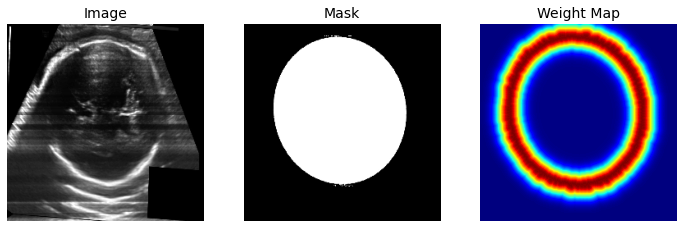

In [8]:
#@title Sample Plot
# get sample
image_s, mask_s, weight_s= next(iter(traindata_loader))

# plot sample from traindata loader
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 6))
ax1.imshow(image_s[0].squeeze().numpy(), cmap="binary_r")
ax1.set_axis_off()
ax1.set_title('Image', fontsize=14)

ax2.imshow(mask_s[0].squeeze().numpy(), cmap="binary_r")
ax2.set_axis_off()
ax2.set_title('Mask', fontsize=14)

ax3.imshow(weight_s[0].numpy(), cmap="jet")
ax3.set_axis_off()
ax3.set_title('Weight Map', fontsize=14)
plt.show()

In [9]:
#@title MiniLinkNet
class BasicConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride):
        super(BasicConv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, stride, 1, 1, 1, False),
                                  nn.BatchNorm2d(out_ch),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(out_ch, out_ch, kernel, 1, 1, 1, 1, False),
                                  nn.BatchNorm2d(out_ch))
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, 0, 1, 1, False),
                                            nn.BatchNorm2d(out_ch))
    
    def forward(self, x):
        out = self.conv(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = out + x
        out = self.relu(out)
        
        return out

class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride):
        super(Encoder, self).__init__()
        self.conv_1 = BasicConv(in_ch, out_ch, kernel, stride)
        self.conv_2 = BasicConv(out_ch, out_ch, kernel, 1)
        
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        
        return out
    
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=2, out_padding=1):
        super(Decoder, self).__init__()
        self.conv_1 = nn.Sequential(nn.Conv2d(in_ch, in_ch//4, 1, 1, 0, 1, 1, False),
                                    nn.BatchNorm2d(in_ch//4),
                                    nn.ReLU(inplace=True))
        
        self.transpose_conv = nn.Sequential(nn.ConvTranspose2d(in_ch//4, in_ch//4, kernel_size, stride, 1, out_padding, 1, False),
                                            nn.BatchNorm2d(in_ch//4),
                                            nn.ReLU(inplace=True))
        
        self.conv_2 = nn.Sequential(nn.Conv2d(in_ch//4, out_ch, 1, 1, 0, 1, 1, False),
                                    nn.BatchNorm2d(out_ch),
                                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        conv_1 = self.conv_1(x)
        transpose_conv = self.transpose_conv(conv_1)
        conv_2 = self.conv_2(transpose_conv)
        
        return conv_2
    
class MiniLinkNet(nn.Module):
    def __init__(self):
        super(MiniLinkNet, self).__init__()
        
        self.conv_1 = nn.Sequential(nn.Conv2d(1, 32, 7, 2, 3, 1,  1, False),
                                    nn.BatchNorm2d(32),
                                    nn.MaxPool2d(3, 2, 1))
        self.half_scale = nn.Conv2d(1, 32, 1, 4, 0, 1, 1, False)
        
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(32, 32, 3, 1, 1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(inplace=True),
                                         nn.ConvTranspose2d(32, 1, 2, 2))
        
        self.encoder1 = Encoder(64, 64, 3, 1)
        self.encoder2 = Encoder(64, 128, 3, 2)
        self.encoder3 = Encoder(128, 256, 3, 2)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1)
        
    def forward(self, x):
        conv_x = self.conv_1(x)
        scale_x = self.half_scale(x)
        feature_map = torch.cat((conv_x, scale_x), 1)
        
        e1 = self.encoder1(feature_map)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Decoder blocks
        d3 = e2 + self.decoder3(e3)
        d2 = e1 + self.decoder2(d3)
        d1 = feature_map + self.decoder1(d2)
        
        out = self.final_layer(d1)
        
        return out

In [12]:
#@title DICE Loss
# DICE LOSS
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, wx, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        LN = (wx * Dice_BCE).view(-1).mean()

        return LN

In [13]:
#@title Lighting Model Trainer
class PlacentModel(pl.LightningModule):
  def __init__(self, lr, model, criterion):
    super(PlacentModel, self).__init__()
    self.model = model
    self.lr = lr
    self.criterion = criterion

  def custom_histogram_adder(self):
    for name,params in self.named_parameters():
        self.logger.experiment.add_histogram(name,params,self.current_epoch)

  def forward(self, x):
    x = self.model(x)
    return x

  def training_step(self, batch, batch_idx):
    x, y, wx = batch
    pred = self(x)
    loss = self.criterion(pred, y, wx)
    metrics = {'loss': loss}
    self.log_dict(metrics, on_step=True, logger=True)
    return metrics

  def validation_step(self, batch, batch_idx):
    x, y, wx = batch
    pred = self(x)
    loss = self.criterion(pred, y, wx)
    metrics = {'val_loss': loss}
    self.log_dict(metrics, on_step=True, logger=True)
    return metrics

  # def training_epoch_end(self, outputs):
  #   self.custom_histogram_adder()
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer

In [17]:
logger = TensorBoardLogger("logs", "MiniLinkNet")

In [16]:
model = MiniLinkNet()
criterion = DiceBCELoss()

In [14]:
trainer = pl.Trainer(max_epochs=100, gpus=-1, deterministic=True, terminate_on_nan=True, 
                     callbacks=[EarlyStopping(monitor="val_loss", patience=5, verbose=True),
                                ModelCheckpoint(filename="/content/drive/MyDrive/Data/mini_re", monitor="val_loss", verbose=True)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
Model = PlacentModel(1e-03, model, criterion)

In [21]:
Model = Model.load_from_checkpoint("/content/drive/MyDrive/Data/mini.ckpt.ckpt", lr=1e-03, model=model, criterion=criterion)

In [22]:
trainer.fit(Model, train_dataloaders=traindata_loader, val_dataloaders=validdata_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | MiniLinkNet | 2.9 M 
1 | criterion | DiceBCELoss | 0     
------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.540    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.231
Epoch 0, global step 466: val_loss reached 0.23071 (best 0.23071), saving model to "/content/drive/MyDrive/Data/mini_re.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 933: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.222
Epoch 2, global step 1400: val_loss reached 0.22248 (best 0.22248), saving model to "/content/drive/MyDrive/Data/mini_re.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1867: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 2334: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 2801: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 3268: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.222. Signaling Trainer to stop.
Epoch 7, global step 3735: val_loss was not in top 1
